### PREPROCESSING & DATA CLEANING - DÉTECTION DE FRAUDE BANCAIRE

**Pipeline complet de préparation des données pour la modélisation**
* **Auditoire :** 3 IDSD ID
* **Date :** septembre 2025

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

#### 1. CHARGEMENT DES DONNÉES ET EXTRACTION DES 300K LIGNES

In [6]:
try:
    # Charger le fichier complet en DataFrame
    df_full = pd.read_csv('C:/Users/MSI/Desktop/Projet MLops/mlops_fraud-main/notebooks/data/fraudAll.csv')
    print(f"✅ Fichier fraudAll.csv chargé avec succès!")
    print(f"   📊 Dimensions totales: {df_full.shape[0]:,} lignes × {df_full.shape[1]} colonnes")
    print(f"   💾 Taille mémoire: {df_full.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("❌ Erreur: Le fichier 'fraudAll.csv' n'a pas été trouvé!")
    print("   Veuillez vérifier que le fichier existe dans le répertoire de travail.")
    raise

✅ Fichier fraudAll.csv chargé avec succès!
   📊 Dimensions totales: 1,296,675 lignes × 23 colonnes
   💾 Taille mémoire: 1034.99 MB


In [7]:
# Définir le nombre de lignes à extraire
n_rows = 3000

In [8]:
if len(df_full) >= n_rows:
    df_300k = df_full.head(n_rows).copy()
    print(f"\n✅ Extraction réussie de {n_rows:,} lignes ({(n_rows/len(df_full)*100):.1f}% du total)")
else:
    df_300k = df_full.copy()
    print(f"\n⚠️  Le fichier contient seulement {len(df_full):,} lignes")
    print(f"   Toutes les lignes seront utilisées")
    n_rows = len(df_full)

print(f"📊 Dimensions extraites: {df_300k.shape[0]:,} lignes × {df_300k.shape[1]} colonnes")


✅ Extraction réussie de 3,000 lignes (0.2% du total)
📊 Dimensions extraites: 3,000 lignes × 23 colonnes


In [9]:
# Vérifier que la distribution de la variable cible est maintenue
if 'is_fraud' in df_300k.columns:
    original_fraud_rate = df_full['is_fraud'].mean() * 100
    extracted_fraud_rate = df_300k['is_fraud'].mean() * 100
    print(f"\n   Vérification de la distribution de la fraude:")
    print(f"   • Taux de fraude original: {original_fraud_rate:.3f}%")
    print(f"   • Taux de fraude extrait: {extracted_fraud_rate:.3f}%")
    if abs(original_fraud_rate - extracted_fraud_rate) < 0.1:
        print(f"✅ Distribution similaire maintenue")
    else:
        print(f"⚠️  Différence de distribution: {abs(original_fraud_rate - extracted_fraud_rate):.3f}%")


   Vérification de la distribution de la fraude:
   • Taux de fraude original: 0.579%
   • Taux de fraude extrait: 0.200%
⚠️  Différence de distribution: 0.379%


In [10]:
# Libérer la mémoire du DataFrame complet
del df_full
import gc
gc.collect()
print("🗑️  Mémoire libérée (DataFrame original supprimé)")

🗑️  Mémoire libérée (DataFrame original supprimé)


In [12]:
df_300k.to_csv('C:/Users/MSI/Desktop/Projet MLops/mlops_fraud-main/notebooks/data/fraud.csv', index=False)
print(f"✅ Export réussi!")
print(f"📁 Fichier créé: fraud.csv ({n_rows:,} lignes)")
print(f"💾 Taille du fichier: ~{df_300k.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Export réussi!
📁 Fichier créé: fraud.csv (3,000 lignes)
💾 Taille du fichier: ~2.39 MB


In [14]:
df = pd.read_csv('C:/Users/MSI/Desktop/Projet MLops/mlops_fraud-main/notebooks/data/fraud.csv')
print(f"✅ Fichier fraud.csv chargé avec succès!")
print(f"📊 Dimensions: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"💾 Utilisation mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Fichier fraud.csv chargé avec succès!
📊 Dimensions: 3,000 lignes × 23 colonnes
💾 Utilisation mémoire: 2.39 MB


#### 2. EXPLORATION INITIALE ET IDENTIFICATION DES TYPES DE VARIABLES

In [15]:
# Aperçu des premières lignes
print("="*80)
print("APERÇU DES DONNÉES")
print("="*80)
display(df.head(10))

APERÇU DES DONNÉES


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
5,5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,Dublin,PA,18917,40.3750,-75.2045,2158,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.653382,-76.152667,0
6,6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,Holcomb,KS,67851,37.9931,-100.9893,2691,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.162705,-100.153370,0
7,7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,Edinburg,VA,22824,38.8432,-78.6003,6018,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.948089,-78.540296,0
8,8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,Manor,PA,15665,40.3359,-79.6607,1472,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.351813,-79.958146,0
9,9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,Clarksville,TN,37040,36.5220,-87.3490,151785,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1325376361,37.179198,-87.485381,0


In [16]:
# Informations sur le dataset
print("\n" + "="*80)
print("INFORMATIONS SUR LES TYPES DE DONNÉES")
print("="*80)
df.info()


INFORMATIONS SUR LES TYPES DE DONNÉES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3000 non-null   int64  
 1   trans_date_trans_time  3000 non-null   object 
 2   cc_num                 3000 non-null   int64  
 3   merchant               3000 non-null   object 
 4   category               3000 non-null   object 
 5   amt                    3000 non-null   float64
 6   first                  3000 non-null   object 
 7   last                   3000 non-null   object 
 8   gender                 3000 non-null   object 
 9   street                 3000 non-null   object 
 10  city                   3000 non-null   object 
 11  state                  3000 non-null   object 
 12  zip                    3000 non-null   int64  
 13  lat                    3000 non-null   float64
 14  long             

In [17]:
# Statistiques descriptives
print("\n" + "="*80)
print("STATISTIQUES DESCRIPTIVES")
print("="*80)
display(df.describe())


STATISTIQUES DESCRIPTIVES


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3000.000000,3000.000000,3000.000000
mean,1499.500000,4.046897e+17,66.053160,49305.629333,38.582682,-90.419408,8.184371e+04,1.325437e+09,38.582955,-90.406705,0.002000
std,866.169729,1.289525e+18,110.245957,27097.713602,5.012744,14.197458,2.679766e+05,3.503952e+04,5.040345,14.216527,0.044684
min,0.000000,6.041621e+10,1.030000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325376e+09,19.209212,-166.148374,0.000000
25%,749.750000,1.800312e+14,9.370000,25505.000000,34.990600,-97.060900,7.590000e+02,1.325411e+09,35.060990,-97.204176,0.000000
50%,1499.500000,3.519607e+15,47.510000,49349.500000,39.423050,-87.724600,2.401000e+03,1.325435e+09,39.392462,-87.648326,0.000000
75%,2249.250000,4.653879e+15,79.407500,72047.000000,41.710000,-80.109900,1.905400e+04,1.325457e+09,41.876506,-80.112288,0.000000
max,2999.000000,4.992346e+18,3178.510000,99783.000000,65.689900,-67.950300,2.906700e+06,1.325515e+09,65.559029,-66.967742,1.000000


In [18]:
# Vérification des valeurs manquantes
print("\n" + "="*80)
print("VALEURS MANQUANTES")
print("="*80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Colonnes': missing.index,
    'Valeurs_Manquantes': missing.values,
    'Pourcentage': missing_pct.values
})
missing_df = missing_df[missing_df['Valeurs_Manquantes'] > 0]
if len(missing_df) > 0:
    display(missing_df)
else:
    print("✅ Aucune valeur manquante détectée!")


VALEURS MANQUANTES
✅ Aucune valeur manquante détectée!



DISTRIBUTION DE LA VARIABLE CIBLE (is_fraud)
Non-fraude (0): 2,994 (99.80%)
Fraude (1): 6 (0.20%)


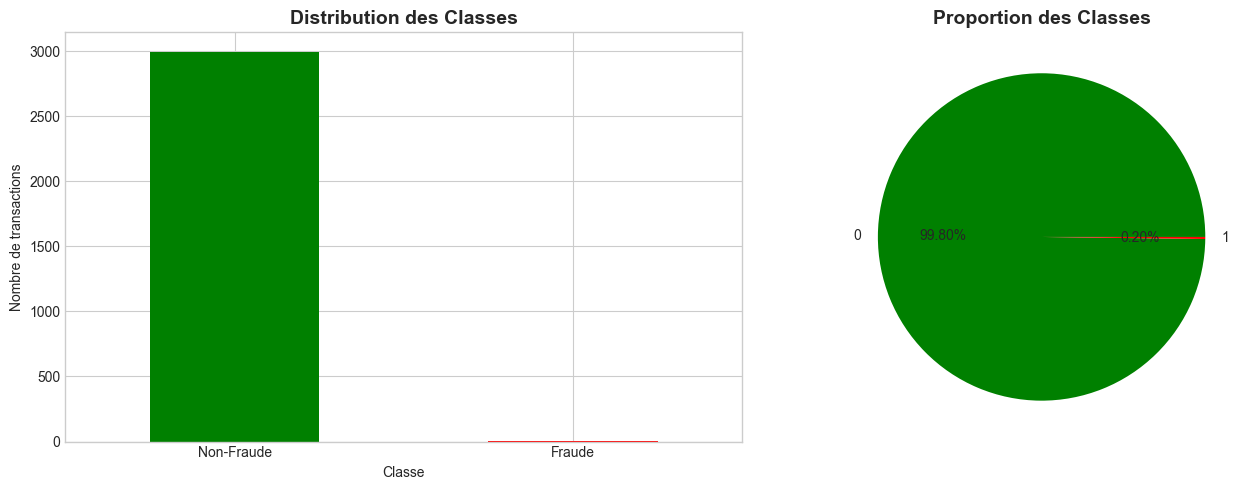

In [19]:
# Distribution de la variable cible
print("\n" + "="*80)
print("DISTRIBUTION DE LA VARIABLE CIBLE (is_fraud)")
print("="*80)
fraud_dist = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100

print(f"Non-fraude (0): {fraud_dist[0]:,} ({fraud_pct[0]:.2f}%)")
if 1 in fraud_dist.index:
    print(f"Fraude (1): {fraud_dist[1]:,} ({fraud_pct[1]:.2f}%)")
else:
    print("⚠️ Aucune fraude détectée dans cet échantillon!")

# Visualisation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
df['is_fraud'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
ax[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Nombre de transactions')
ax[0].set_xticklabels(['Non-Fraude', 'Fraude'], rotation=0)

df['is_fraud'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.2f%%', colors=['green', 'red'])
ax[1].set_title('Proportion des Classes', fontsize=14, fontweight='bold')
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

#### 3. NETTOYAGE DES DONNÉES

In [20]:
print("="*80)
print("NETTOYAGE DES DONNÉES")
print("="*80)

# Créer une copie pour le preprocessing
df_clean = df.copy()

# Supprimer la colonne d'index inutile
if 'Unnamed: 0' in df_clean.columns:
    df_clean = df_clean.drop('Unnamed: 0', axis=1)
    print("✓ Colonne 'Unnamed: 0' supprimée")

# Convertir les types de données
df_clean['trans_date_trans_time'] = pd.to_datetime(df_clean['trans_date_trans_time'])
df_clean['dob'] = pd.to_datetime(df_clean['dob'])
print("✓ Dates converties en format datetime")

print(f"\n✓ Dataset nettoyé: {df_clean.shape[0]:,} lignes × {df_clean.shape[1]} colonnes")

NETTOYAGE DES DONNÉES
✓ Colonne 'Unnamed: 0' supprimée
✓ Dates converties en format datetime

✓ Dataset nettoyé: 3,000 lignes × 22 colonnes


#### 4. INGÉNIERIE DES FEATURES

In [21]:
print("="*80)
print("INGÉNIERIE DES FEATURES")
print("="*80)

# 4.1 Features temporelles
print("\n📅 Création des features temporelles...")
df_clean['trans_hour'] = df_clean['trans_date_trans_time'].dt.hour
df_clean['trans_day'] = df_clean['trans_date_trans_time'].dt.day
df_clean['trans_month'] = df_clean['trans_date_trans_time'].dt.month
df_clean['trans_year'] = df_clean['trans_date_trans_time'].dt.year
df_clean['trans_dayofweek'] = df_clean['trans_date_trans_time'].dt.dayofweek
df_clean['is_weekend'] = (df_clean['trans_dayofweek'] >= 5).astype(int)
print("   ✓ trans_hour, trans_day, trans_month, trans_year")
print("   ✓ trans_dayofweek, is_weekend")

# 4.2 Âge du client
print("\n👤 Calcul de l'âge...")
df_clean['age'] = (df_clean['trans_date_trans_time'] - df_clean['dob']).dt.days / 365.25
print(f"   ✓ Âge moyen: {df_clean['age'].mean():.1f} ans")

# 4.3 Distance entre client et marchand (formule de Haversine)
print("\n📍 Calcul de la distance client-marchand...")
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Rayon de la Terre en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df_clean['distance_km'] = haversine_distance(
    df_clean['lat'], df_clean['long'],
    df_clean['merch_lat'], df_clean['merch_long']
)
print(f"   ✓ Distance moyenne: {df_clean['distance_km'].mean():.2f} km")

# 4.4 Catégories de montant
print("\n💰 Création des catégories de montant...")
df_clean['amt_category'] = pd.cut(df_clean['amt'], 
                                   bins=[0, 50, 100, 200, float('inf')],
                                   labels=['faible', 'moyen', 'élevé', 'très_élevé'])
print("   ✓ Catégories: faible (<50), moyen (50-100), élevé (100-200), très_élevé (>200)")

# 4.5 Période de la journée
print("\n🕐 Création de la période de la journée...")
def get_period(hour):
    if 6 <= hour < 12:
        return 'matin'
    elif 12 <= hour < 18:
        return 'après-midi'
    elif 18 <= hour < 22:
        return 'soirée'
    else:
        return 'nuit'

df_clean['day_period'] = df_clean['trans_hour'].apply(get_period)
print("   ✓ Périodes: matin, après-midi, soirée, nuit")

print(f"\n✅ Total features: {df_clean.shape[1]} (+ {df_clean.shape[1] - df.shape[1]} nouvelles)")

INGÉNIERIE DES FEATURES

📅 Création des features temporelles...
   ✓ trans_hour, trans_day, trans_month, trans_year
   ✓ trans_dayofweek, is_weekend

👤 Calcul de l'âge...
   ✓ Âge moyen: 46.2 ans

📍 Calcul de la distance client-marchand...
   ✓ Distance moyenne: 75.79 km

💰 Création des catégories de montant...
   ✓ Catégories: faible (<50), moyen (50-100), élevé (100-200), très_élevé (>200)

🕐 Création de la période de la journée...
   ✓ Périodes: matin, après-midi, soirée, nuit

✅ Total features: 32 (+ 9 nouvelles)


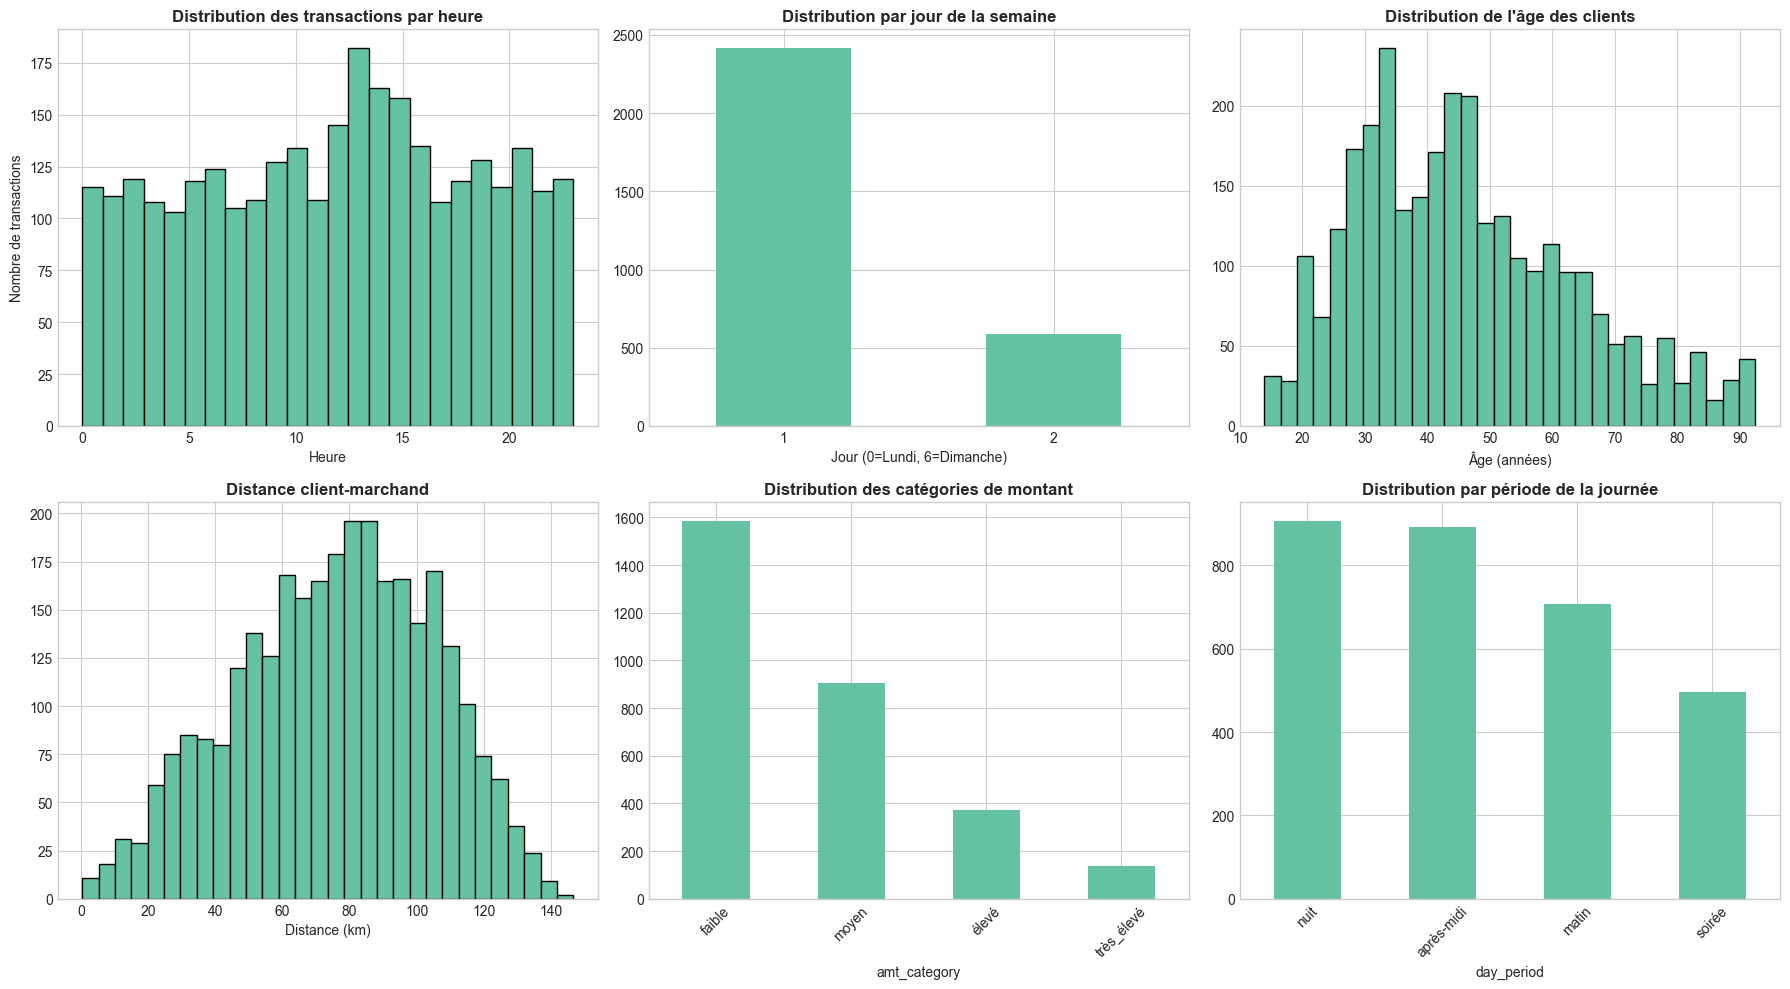

In [22]:
# Visualisation des nouvelles features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Distribution par heure
df_clean['trans_hour'].hist(ax=axes[0,0], bins=24, edgecolor='black')
axes[0,0].set_title('Distribution des transactions par heure', fontweight='bold')
axes[0,0].set_xlabel('Heure')
axes[0,0].set_ylabel('Nombre de transactions')

# Distribution par jour de la semaine
df_clean['trans_dayofweek'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Distribution par jour de la semaine', fontweight='bold')
axes[0,1].set_xlabel('Jour (0=Lundi, 6=Dimanche)')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=0)

# Distribution de l'âge
df_clean['age'].hist(ax=axes[0,2], bins=30, edgecolor='black')
axes[0,2].set_title('Distribution de l\'âge des clients', fontweight='bold')
axes[0,2].set_xlabel('Âge (années)')

# Distribution de la distance
df_clean['distance_km'].hist(ax=axes[1,0], bins=30, edgecolor='black')
axes[1,0].set_title('Distance client-marchand', fontweight='bold')
axes[1,0].set_xlabel('Distance (km)')

# Catégories de montant
df_clean['amt_category'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Distribution des catégories de montant', fontweight='bold')
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)

# Période de la journée
df_clean['day_period'].value_counts().plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Distribution par période de la journée', fontweight='bold')
axes[1,2].set_xticklabels(axes[1,2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

#### 5. SÉLECTION ET PRÉPARATION DES VARIABLES

In [23]:
print("="*80)
print("SÉLECTION DES VARIABLES")
print("="*80)

# Colonnes à supprimer (identifiants, dates, adresses textuelles)
cols_to_drop = [
    'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last',
    'street', 'trans_num', 'dob', 'unix_time', 'city'
]

# Variables catégorielles à encoder
categorical_features = ['category', 'gender', 'state', 'job', 'amt_category', 'day_period']

# Variables numériques à normaliser
numerical_features = [
    'amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
    'trans_hour', 'trans_day', 'trans_month', 'trans_year', 'trans_dayofweek',
    'is_weekend', 'age', 'distance_km'
]

# Variable cible
target = 'is_fraud'

# Créer le dataset final
df_model = df_clean.drop(columns=cols_to_drop)
print(f"✓ Colonnes supprimées: {len(cols_to_drop)}")
print(f"✓ Variables catégorielles: {len(categorical_features)}")
print(f"✓ Variables numériques: {len(numerical_features)}")
print(f"\n✓ Dataset final: {df_model.shape[0]:,} lignes × {df_model.shape[1]} colonnes")

SÉLECTION DES VARIABLES
✓ Colonnes supprimées: 10
✓ Variables catégorielles: 6
✓ Variables numériques: 15

✓ Dataset final: 3,000 lignes × 22 colonnes


#### 6. ENCODAGE DES VARIABLES CATÉGORIELLES

In [24]:
print("="*80)
print("ENCODAGE DES VARIABLES CATÉGORIELLES")
print("="*80)

# Dictionnaire pour stocker les encodeurs
label_encoders = {}

for col in categorical_features:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le
        print(f"✓ {col}: {len(le.classes_)} classes encodées")
        
print(f"\n✅ {len(label_encoders)} variables encodées avec succès")

ENCODAGE DES VARIABLES CATÉGORIELLES
✓ category: 14 classes encodées
✓ gender: 2 classes encodées
✓ state: 50 classes encodées
✓ job: 458 classes encodées
✓ amt_category: 4 classes encodées
✓ day_period: 4 classes encodées

✅ 6 variables encodées avec succès


#### 7. SÉPARATION FEATURES / TARGET

In [25]:
print("="*80)
print("SÉPARATION DES DONNÉES")
print("="*80)

X = df_model.drop(target, axis=1)
y = df_model[target]

print(f"✓ Features (X): {X.shape}")
print(f"✓ Target (y): {y.shape}")
print(f"✓ Taux de fraude: {y.mean()*100:.2f}%")
print(f"\n📋 Liste des features:")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

SÉPARATION DES DONNÉES
✓ Features (X): (3000, 21)
✓ Target (y): (3000,)
✓ Taux de fraude: 0.20%

📋 Liste des features:
    1. category
    2. amt
    3. gender
    4. state
    5. zip
    6. lat
    7. long
    8. city_pop
    9. job
   10. merch_lat
   11. merch_long
   12. trans_hour
   13. trans_day
   14. trans_month
   15. trans_year
   16. trans_dayofweek
   17. is_weekend
   18. age
   19. distance_km
   20. amt_category
   21. day_period


#### 8. TRAIN/TEST SPLIT

In [26]:
print("="*80)
print("SÉPARATION TRAIN/TEST")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.sum() > 0 else None
)

print(f"\n✓ Train set: {X_train.shape[0]} échantillons ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✓ Test set: {X_test.shape[0]} échantillons ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n📊 Distribution dans train set:")
print(f"   Non-fraude: {(y_train == 0).sum():,}")
print(f"   Fraude: {(y_train == 1).sum():,}")
print(f"\n📊 Distribution dans test set:")
print(f"   Non-fraude: {(y_test == 0).sum():,}")
print(f"   Fraude: {(y_test == 1).sum():,}")

SÉPARATION TRAIN/TEST

✓ Train set: 2400 échantillons (80.0%)
✓ Test set: 600 échantillons (20.0%)

📊 Distribution dans train set:
   Non-fraude: 2,395
   Fraude: 5

📊 Distribution dans test set:
   Non-fraude: 599
   Fraude: 1


#### 9. NORMALISATION DES VARIABLES NUMÉRIQUES

In [27]:
print("="*80)
print("NORMALISATION DES DONNÉES")
print("="*80)

# Utiliser RobustScaler (plus robuste aux outliers)
scaler = RobustScaler()

# Identifier les colonnes numériques dans X_train
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"✓ {len(numeric_cols)} variables numériques normalisées avec RobustScaler")
print(f"\n📊 Exemple de normalisation (5 premières features):")
comparison = pd.DataFrame({
    'Feature': numeric_cols[:5],
    'Mean_avant': [X_train[col].mean() for col in numeric_cols[:5]],
    'Std_avant': [X_train[col].std() for col in numeric_cols[:5]],
    'Mean_après': [X_train_scaled[col].mean() for col in numeric_cols[:5]],
    'Std_après': [X_train_scaled[col].std() for col in numeric_cols[:5]]
})
display(comparison)

NORMALISATION DES DONNÉES
✓ 21 variables numériques normalisées avec RobustScaler

📊 Exemple de normalisation (5 premières features):


,Feature,Mean_avant,Std_avant,Mean_après,Std_après
0,category,6.158333,3.836152,0.022619,0.548022
1,amt,67.069046,118.575080,0.291380,1.689585
2,gender,0.445833,0.497161,0.445833,0.497161
3,state,25.647500,14.140187,-0.015326,0.614791
4,zip,49186.387917,27261.208974,0.006062,0.584224


#### 10. GESTION DU DÉSÉQUILIBRE DES CLASSES (SMOTE)

In [28]:
print("="*80)
print("GESTION DU DÉSÉQUILIBRE DES CLASSES")
print("="*80)

print(f"\n📊 Distribution AVANT SMOTE:")
print(f"  Classe 0 (Non-fraude): {Counter(y_train)[0]:,}")
if 1 in Counter(y_train):
    print(f"  Classe 1 (Fraude): {Counter(y_train)[1]:,}")
    print(f"  Ratio: {Counter(y_train)[0]/Counter(y_train)[1]:.2f}:1")
    
    # Appliquer SMOTE seulement s'il y a des cas de fraude
    smote = SMOTE(random_state=42, k_neighbors=min(5, Counter(y_train)[1]-1))
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"\n📊 Distribution APRÈS SMOTE:")
    print(f"  Classe 0 (Non-fraude): {Counter(y_train_resampled)[0]:,}")
    print(f"  Classe 1 (Fraude): {Counter(y_train_resampled)[1]:,}")
    print(f"  Ratio: 1:1 (équilibré)")
    
    smote_applied = True
    print(f"\n✅ SMOTE appliqué avec succès!")
    print(f"   Échantillons synthétiques créés: {len(X_train_resampled) - len(X_train_scaled):,}")
else:
    print("\n⚠️ Pas de fraude dans le train set - SMOTE non applicable")
    X_train_resampled = X_train_scaled
    y_train_resampled = y_train
    smote_applied = False

GESTION DU DÉSÉQUILIBRE DES CLASSES

📊 Distribution AVANT SMOTE:
  Classe 0 (Non-fraude): 2,395
  Classe 1 (Fraude): 5
  Ratio: 479.00:1

📊 Distribution APRÈS SMOTE:
  Classe 0 (Non-fraude): 2,395
  Classe 1 (Fraude): 2,395
  Ratio: 1:1 (équilibré)

✅ SMOTE appliqué avec succès!
   Échantillons synthétiques créés: 2,390


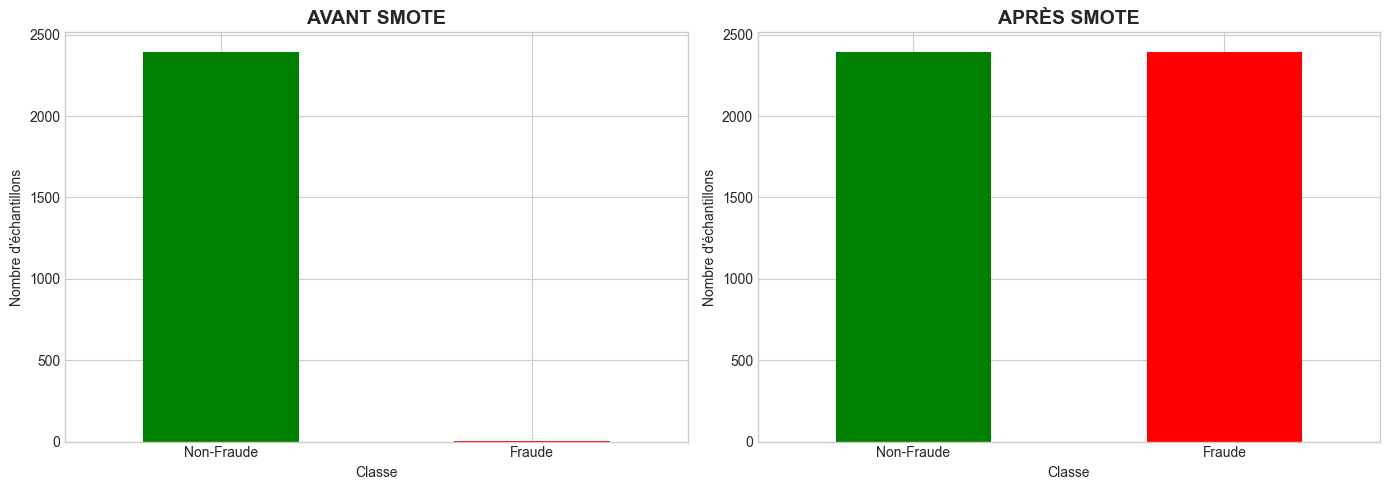

In [29]:
# Visualisation de l'effet de SMOTE
if smote_applied:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Avant SMOTE
    pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
    axes[0].set_title('AVANT SMOTE', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Classe')
    axes[0].set_ylabel('Nombre d\'échantillons')
    axes[0].set_xticklabels(['Non-Fraude', 'Fraude'], rotation=0)
    
    # Après SMOTE
    pd.Series(y_train_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
    axes[1].set_title('APRÈS SMOTE', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Classe')
    axes[1].set_ylabel('Nombre d\'échantillons')
    axes[1].set_xticklabels(['Non-Fraude', 'Fraude'], rotation=0)
    
    plt.tight_layout()
    plt.show()

In [30]:
X_train_resampled.head()

,category,amt,gender,state,zip,lat,long,city_pop,job,merch_lat,merch_long,trans_hour,trans_day,trans_month,trans_year,trans_dayofweek,is_weekend,age,distance_km,amt_category,day_period
0,0.000000,-0.413508,0.0,-0.956522,0.999191,0.141779,-2.123474,-0.070741,0.850427,0.041198,-2.170647,0.090909,0.0,0.0,0.0,0.0,0.0,0.923513,0.814998,0.0,-0.5
1,-0.571429,0.204759,0.0,0.304348,-0.761697,0.494903,0.745369,-0.088482,0.897436,0.443332,0.698685,-0.909091,1.0,0.0,0.0,1.0,0.0,-0.416283,-0.087366,1.0,0.5
2,-0.428571,0.013109,1.0,0.434783,1.048160,0.928818,-1.803797,-0.061560,-0.559829,0.904815,-1.808547,-0.181818,0.0,0.0,0.0,0.0,0.0,-0.073150,-1.054700,0.0,0.0
3,0.714286,0.588344,1.0,-0.565217,0.269458,0.138600,-0.157230,-0.099352,-0.205128,0.167050,-0.118404,-0.818182,0.0,0.0,0.0,0.0,0.0,0.069018,-0.264643,1.0,0.5
4,-0.571429,0.223710,0.0,0.347826,-0.070325,-0.028690,0.297003,-0.116812,-0.598291,0.056004,0.266427,-0.090909,1.0,0.0,0.0,1.0,0.0,-0.176757,-0.411429,1.0,0.0


#### 11. SAUVEGARDE DES PROCESSEURS

In [31]:
print("="*80)
print("SAUVEGARDE DES PROCESSEURS")
print("="*80)

# Créer le dossier pour les modèles
os.makedirs('processors', exist_ok=True)

# 1. Sauvegarder le scaler
with open('processors/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler sauvegardé: processors/scaler.pkl")

# 2. Sauvegarder les label encoders
with open('processors/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Label encoders sauvegardés: processors/label_encoders.pkl")

# 3. Sauvegarder les noms de colonnes
feature_names = {
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'all_features': X.columns.tolist()
}
with open('processors/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✓ Noms des features sauvegardés: processors/feature_names.pkl")

# 4. Sauvegarder SMOTE config
if smote_applied:
    smote_config = {
        'applied': True,
        'strategy': 'SMOTE',
        'random_state': 42
    }
else:
    smote_config = {'applied': False}
    
with open('processors/smote_config.pkl', 'wb') as f:
    pickle.dump(smote_config, f)
print("✓ Configuration SMOTE sauvegardée: processors/smote_config.pkl")

# 5. Sauvegarder les données preprocessées
datasets = {
    'X_train': X_train_resampled,
    'X_test': X_test_scaled,
    'y_train': y_train_resampled,
    'y_test': y_test
}
with open('processors/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(datasets, f)
print("✓ Données preprocessées sauvegardées: processors/preprocessed_data.pkl")

print(f"\n✅ Tous les processeurs ont été sauvegardés dans le dossier 'processors/'")

SAUVEGARDE DES PROCESSEURS
✓ Scaler sauvegardé: processors/scaler.pkl
✓ Label encoders sauvegardés: processors/label_encoders.pkl
✓ Noms des features sauvegardés: processors/feature_names.pkl
✓ Configuration SMOTE sauvegardée: processors/smote_config.pkl
✓ Données preprocessées sauvegardées: processors/preprocessed_data.pkl

✅ Tous les processeurs ont été sauvegardés dans le dossier 'processors/'


#### 12. RÉSUMÉ DU PREPROCESSING

In [32]:
print("="*80)
print("RÉSUMÉ DU PREPROCESSING")
print("="*80)
print(f"""
📊 DONNÉES FINALES:
   • Train set: {X_train_resampled.shape[0]:,} échantillons × {X_train_resampled.shape[1]} features
   • Test set: {X_test_scaled.shape[0]:,} échantillons × {X_test_scaled.shape[1]} features
   • Features totales: {X.shape[1]}
   
🔧 TRANSFORMATIONS APPLIQUÉES:
   • Nettoyage des données
   • Ingénierie de {len(X.columns) - len(df.columns) + len(cols_to_drop)} nouvelles features
   • Encodage de {len(categorical_features)} variables catégorielles
   • Normalisation de {len(numeric_cols)} variables numériques
   • Rééchantillonnage avec SMOTE: {'Oui' if smote_applied else 'Non'}
   
💾 FICHIERS SAUVEGARDÉS:
   • processor/scaler.pkl
   • processor/label_encoders.pkl
   • processor/feature_names.pkl
   • processor/smote_config.pkl
   • processor/preprocessed_data.pkl
   
✅ PREPROCESSING TERMINÉ!
""")

RÉSUMÉ DU PREPROCESSING

📊 DONNÉES FINALES:
   • Train set: 4,790 échantillons × 21 features
   • Test set: 600 échantillons × 21 features
   • Features totales: 21
   
🔧 TRANSFORMATIONS APPLIQUÉES:
   • Nettoyage des données
   • Ingénierie de 8 nouvelles features
   • Encodage de 6 variables catégorielles
   • Normalisation de 21 variables numériques
   • Rééchantillonnage avec SMOTE: Oui
   
💾 FICHIERS SAUVEGARDÉS:
   • processor/scaler.pkl
   • processor/label_encoders.pkl
   • processor/feature_names.pkl
   • processor/smote_config.pkl
   • processor/preprocessed_data.pkl
   
✅ PREPROCESSING TERMINÉ!



#### 13. EXEMPLE DE CHARGEMENT DES PROCESSEURS

In [34]:
print("="*80)
print("EXEMPLE DE CHARGEMENT DES PROCESSEURS")
print("="*80)

# Pour charger les processeurs plus tard:

import pickle

# Charger le scaler
with open('processors/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Charger les encoders
with open('processors/label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

# Charger les noms de features
with open('processors/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

# Charger les données
with open('processors/preprocessed_data.pkl', 'rb') as f:
    datasets = pickle.load(f)
    X_train = datasets['X_train']
    X_test = datasets['X_test']
    y_train = datasets['y_train']
    y_test = datasets['y_test']


print("\n" + "="*80)
print("🎉 NOTEBOOK DE PREPROCESSING TERMINÉ!")
print("="*80)
print("\nProchaines étapes:")
print("  1. Entraîner des modèles de classification")
print("  2. Évaluer les performances")
print("  3. Optimiser les hyperparamètres")
print("  4. Déployer le meilleur modèle")

EXEMPLE DE CHARGEMENT DES PROCESSEURS

🎉 NOTEBOOK DE PREPROCESSING TERMINÉ!

Prochaines étapes:
  1. Entraîner des modèles de classification
  2. Évaluer les performances
  3. Optimiser les hyperparamètres
  4. Déployer le meilleur modèle
